# Generate D1 Magnet with STEAM-SIGMA
<img src = "FRESCA2.png" width=50%>

# Import Java gateway and STEAM API (SING, UTILS)

In [2]:
from py4j.java_gateway import launch_gateway, java_import, JavaGateway, JavaObject, GatewayParameters, Py4JNetworkError

# Launch a Gateway in a new Java process, this returns port
port = launch_gateway(classpath='../../steam/*')

# JavaGateway instance is connected to a Gateway instance on the Java side
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=port))

import numpy as np
import math
import pandas as pd
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.pyplot as plt
%matplotlib inline

# Load steam-sigma API
Point = gateway.jvm.model.geometry.basic.Point
Line = gateway.jvm.model.geometry.basic.Line
Arc = gateway.jvm.model.geometry.basic.Arc
Circumference = gateway.jvm.model.geometry.basic.Circumference
Area = gateway.jvm.model.geometry.basic.Area
HyperLine = gateway.jvm.model.geometry.basic.HyperLine
Element = gateway.jvm.model.geometry.Element
Domain = gateway.jvm.model.domains.Domain
AirDomain = gateway.jvm.model.domains.database.AirDomain
AirFarFieldDomain = gateway.jvm.model.domains.database.AirFarFieldDomain
IronDomain = gateway.jvm.model.domains.database.IronDomain
HoleDomain = gateway.jvm.model.domains.database.HoleDomain
CoilDomain = gateway.jvm.model.domains.database.CoilDomain
MatDatabase = gateway.jvm.model.materials.database.MatDatabase
ConfigSigma = gateway.jvm.config.ConfigSigma
TxtSigmaServer = gateway.jvm.server.TxtSigmaServer
MagnetMPHBuilder = gateway.jvm.comsol.MagnetMPHBuilder
Cable = gateway.jvm.model.geometry.coil.Cable
Winding = gateway.jvm.model.geometry.coil.Winding
Pole = gateway.jvm.model.geometry.coil.Pole
Coil = gateway.jvm.model.geometry.coil.Coil

In [3]:
import sys
import os
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])
utilities_dir = str(curr_dir.parent / 'steam')

if utilities_dir not in sys.path:
    sys.path.append(utilities_dir)
    
import plotting as p
import arrays as a

(-1.05, 1.05)

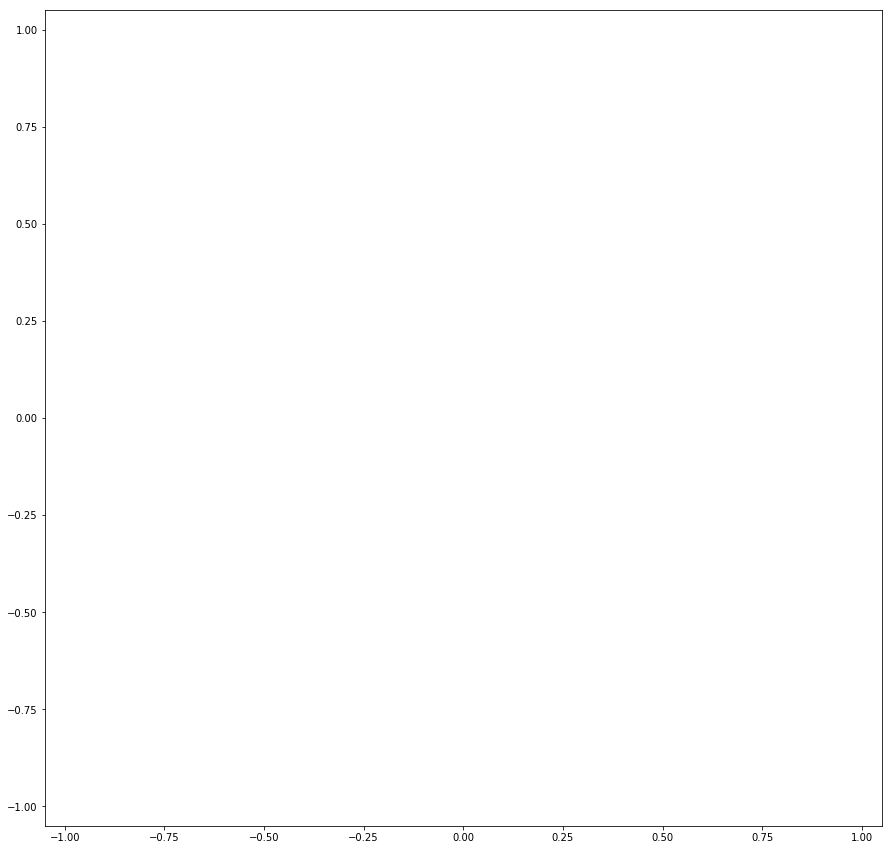

In [4]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)

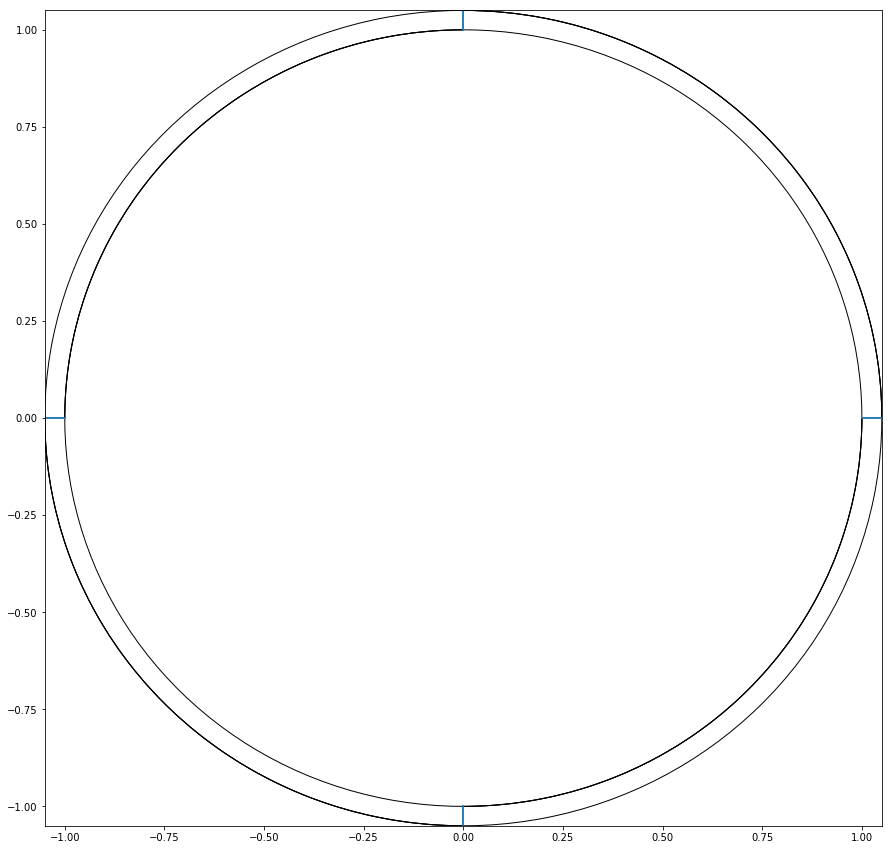

In [5]:
#Air far field
r = 1.0;

kpc = Point.ofCartesian(0.0, 0.0)
kp1 = Point.ofCartesian(r, 0.0)
kp2 = Point.ofCartesian(0.0, r)

kp1_far = Point.ofCartesian(r * 1.05, 0.0)
kp2_far = Point.ofCartesian(0.0, r * 1.05)

ln1_far = Line.ofEndPoints(kp1, kp1_far)
ln2_far = Arc.ofEndPointsCenter(kp1_far, kp2_far, kpc)
ln3_far = Line.ofEndPoints(kp2_far, kp2)
ln4_far = Arc.ofEndPointsCenter(kp2, kp1, kpc)

ar1_far = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln1_far, ln2_far, ln3_far, ln4_far)))
ar2_far = ar1_far.mirrorY()
ar3_far = ar2_far.mirrorX()
ar4_far = ar1_far.mirrorX()

el1_far = Element("FAR_El1", ar1_far)
el2_far = Element("FAR_El2", ar2_far)
el3_far = Element("FAR_El3", ar3_far)
el4_far = Element("FAR_El4", ar4_far)

air_far_field = a.create_element_array(gateway, (el1_far, el2_far, el3_far, el4_far))

p.plot_multiple_areas(ax, [ar1_far, ar2_far, ar3_far, ar4_far])
fig

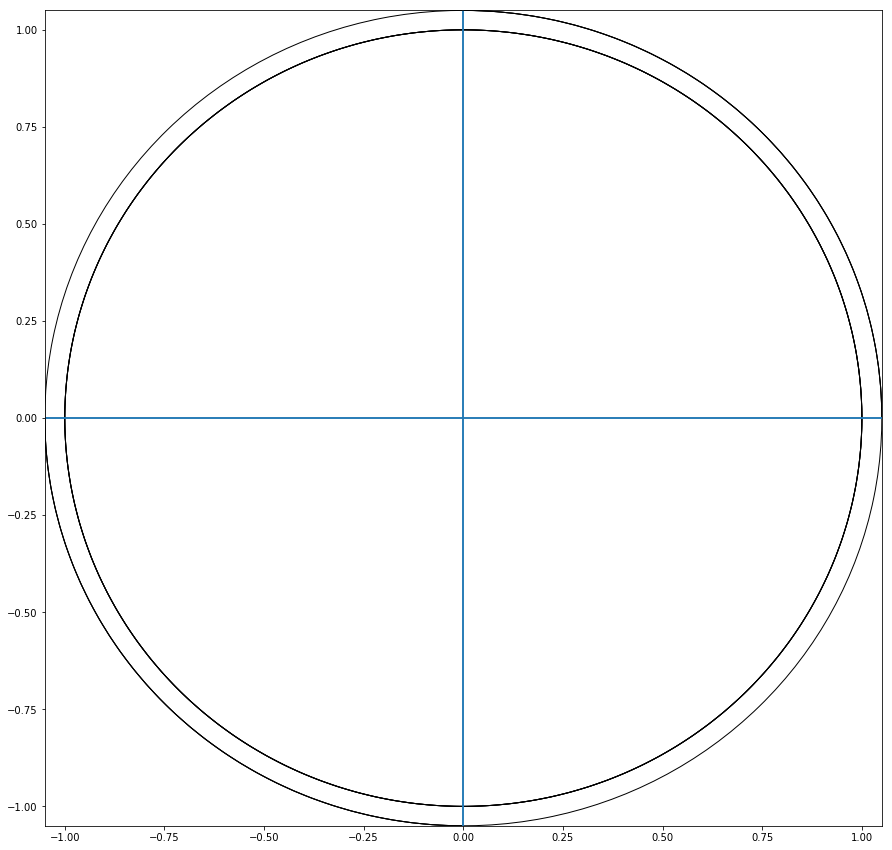

In [6]:
# Air domain
r = 1.0

kpc = Point.ofCartesian(0.0, 0.0)
kp1 = Point.ofCartesian(r, 0.0)
kp2 = Point.ofCartesian(0.0, r)

ln1 = Line.ofEndPoints(kpc, kp1)
ln2 = Arc.ofEndPointsCenter(kp1, kp2, kpc)
ln3 = Line.ofEndPoints(kp2, kpc)

ar1 = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln1, ln2, ln3)))
ar2 = ar1.mirrorY()
ar3 = ar2.mirrorX()
ar4 = ar1.mirrorX()

el1 = Element("AIR_El1", ar1)
el2 = Element("AIR_El2", ar2)
el3 = Element("AIR_El3", ar3)
el4 = Element("AIR_El4", ar4)

air = a.create_element_array(gateway, (el1, el2, el3, el4))

p.plot_multiple_areas(ax, [ar1, ar2, ar3, ar4])
fig

In [7]:
# iron yoke variables
mm = 0.001
deg = np.pi/180
t_cbl = 2.22*mm
n1 = 36
n3 = 42
x1 = 137.92*mm
y1 = 3.5*mm
y5 = 93.20*mm
y3 = 0.5*(y1+y5)
x1l = x1-n1*t_cbl
x3l = x1-n3*t_cbl
r_fillet_top_pole = 8*mm
t_top_pole_nose = 6*mm
x_top_pole_corner = 12.5*mm
y_top_pole_bottom = 62.5*mm
angle_poles = math.atan((y_top_pole_bottom-y3)/(x3l-t_top_pole_nose-x_top_pole_corner))
w_vpad = 296*mm
t_top_plate = 18*mm
t_vpad = 141.8*mm
r_yoke = 450*mm
yoke_gap = 5.*mm
r_fillet_yoke = 20*mm
x_yoke_hole = 62.5*mm
y_yoke_hole = 300*mm
dia_yoke_hole = 60*mm
t_key = 10*mm
w_key = 35*mm
w_bladd = 75*mm
gap_coil_iron_top_pole = 0.75*mm
gap_coil_iron_vpad = 0.75*mm

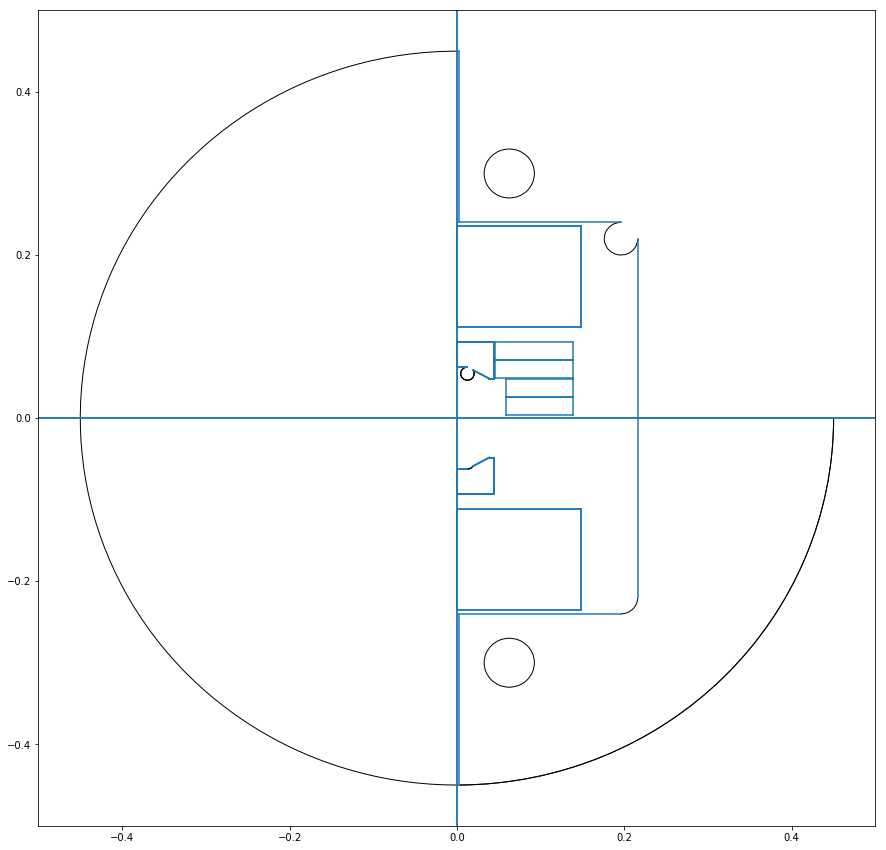

In [19]:
# iron yoke 1
kp_251 = Point.ofCartesian(0.0, y_top_pole_bottom)
kp_252 = Point.ofCartesian(x_top_pole_corner, y_top_pole_bottom)
kp_253 = Point.ofCartesian(x_top_pole_corner+r_fillet_top_pole*np.sin(2*angle_poles), y_top_pole_bottom-r_fillet_top_pole+r_fillet_top_pole*np.cos(2*angle_poles))
kp_254 = Point.ofCartesian(x3l-t_top_pole_nose, y3)
kp_255 = Point.ofCartesian(x3l-gap_coil_iron_top_pole, y3)
kp_256 = Point.ofCartesian(x3l-gap_coil_iron_top_pole, y5)
kp_257 = Point.ofCartesian(0.0, y5)

ln_251 = Line.ofEndPoints(kp_251,kp_252)
ln_252 = Arc.ofEndPointsRadius(kp_252,kp_253,r_fillet_top_pole)
ln_253 = Line.ofEndPoints(kp_253,kp_254)
ln_254 = Line.ofEndPoints(kp_254,kp_255)
ln_255 = Line.ofEndPoints(kp_255,kp_256)
ln_256 = Line.ofEndPoints(kp_256,kp_257)
ln_257 = Line.ofEndPoints(kp_257,kp_251)

ar_251 = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln_251,ln_252,ln_253,ln_254,ln_255,ln_256,ln_257)))
ar_251_mirror_x = ar_251.mirrorX()

el1_251 = Element("IY1_El1",ar_251)
el2_251 = Element("IY1_El2",ar_251_mirror_x)

iron_yoke1 = a.create_element_array(gateway, (el1_251, el2_251))

p.plot_multiple_areas(ax, [ar_251, ar_251_mirror_x])

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
fig

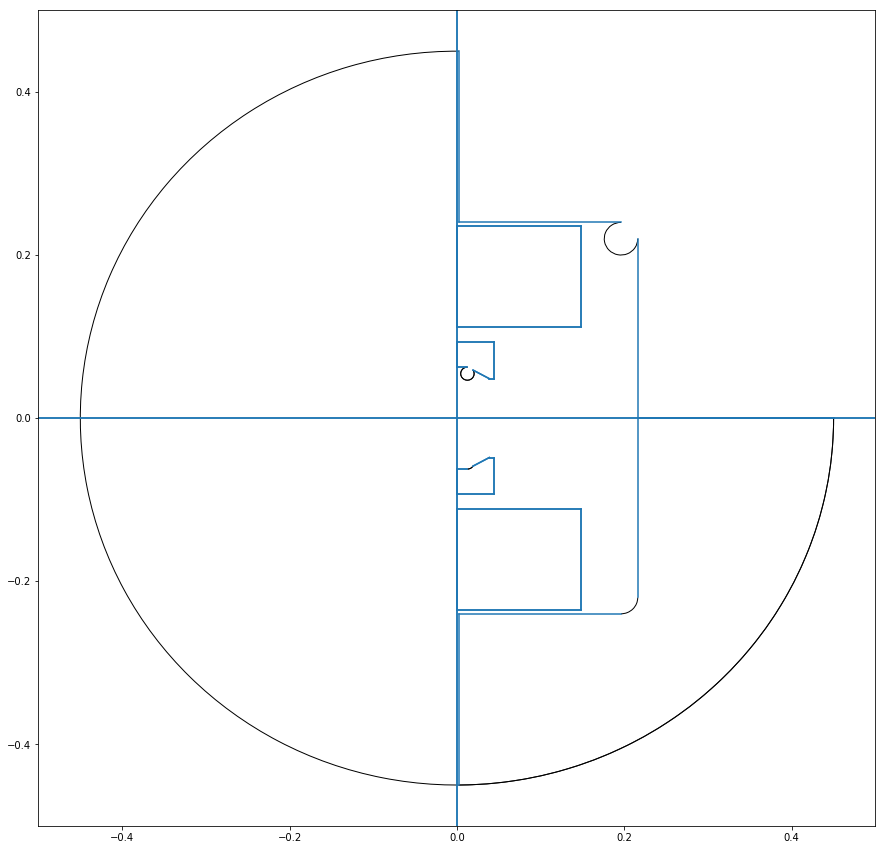

In [12]:
# Iron yoke 2
kp_701 = Point.ofCartesian(0.0, y5+t_top_plate)
kp_702 = Point.ofCartesian(0.5*w_vpad, y5+t_top_plate)
kp_703 = Point.ofCartesian(0.5*w_vpad, y5+t_vpad)
kp_704 = Point.ofCartesian(0.0, y5+t_vpad)
ln_701 = Line.ofEndPoints(kp_701,kp_702)
ln_702 = Line.ofEndPoints(kp_702,kp_703)
ln_703 = Line.ofEndPoints(kp_703,kp_704)
ln_704 = Line.ofEndPoints(kp_704,kp_701)

ar_701 = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln_701,ln_702,ln_703,ln_704)))

ar_701_mirror_x = ar_701.mirrorX()

el1_701 = Element("IY2_El1", ar_701)
el2_701 = Element("IY2_El2", ar_701_mirror_x)

kp_1001 = Point.ofCartesian(216.0*mm, 0.0)
kp_1002 = Point.ofCartesian(r_yoke, 0.)
kp_1003 = Point.ofCartesian(0.5*yoke_gap, np.sqrt(r_yoke*r_yoke-0.25*yoke_gap*yoke_gap))
kp_1004 = Point.ofCartesian(0.5*yoke_gap, y5+t_vpad+0.5*t_key)
kp_1005 = Point.ofCartesian(216.0*mm-r_fillet_yoke, y5+t_vpad+0.5*t_key)
kp_1006 = Point.ofCartesian(216.0*mm, y5+t_vpad+0.5*t_key-r_fillet_yoke)
ln_1001 = Line.ofEndPoints(kp_1001, kp_1002)
ln_1002 = Arc.ofEndPointsRadius(kp_1003,kp_1002, r_yoke)
ln_1003 = Line.ofEndPoints(kp_1003, kp_1004)
ln_1004 = Line.ofEndPoints(kp_1004, kp_1005)
ln_1005 = Arc.ofEndPointsRadius(kp_1005, kp_1006, r_fillet_yoke)
ln_1006 = Line.ofEndPoints(kp_1006, kp_1001)

ar_1001  = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln_1001, ln_1002, ln_1003, ln_1004, ln_1005, ln_1006)))
ar_1001_mirror_x = ar_1001.mirrorX()

el1_1001 = Element("IY2_El3", ar_1001)
el2_1001 = Element("IY2_El4", ar_1001_mirror_x)

iron_yoke2 = a.create_element_array(gateway, (el1_701, el1_1001, el2_701, el2_1001))

p.plot_multiple_areas(ax, [ar_701, ar_1001, ar_701_mirror_x, ar_1001_mirror_x])

fig

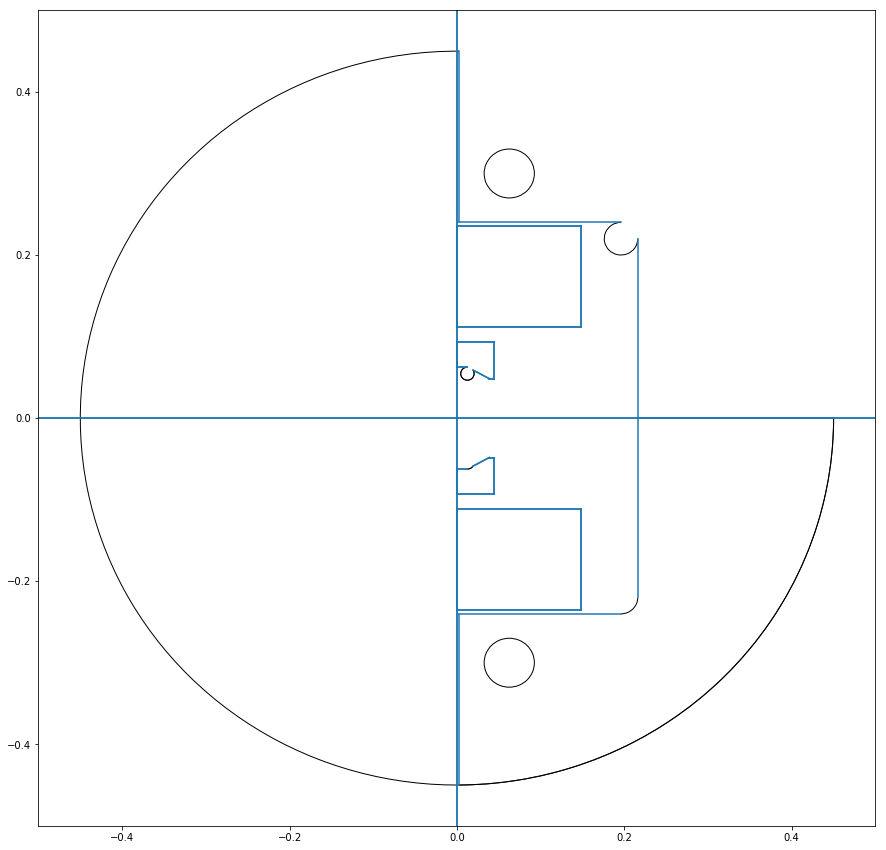

In [13]:
# iron yoke holes
kpyokehole = Point.ofCartesian(x_yoke_hole, y_yoke_hole)
lnyokehole = Circumference.ofCenterRadius(kpyokehole, 0.5*dia_yoke_hole)

aryokehole = Area.ofHyperLines(a.create_hyper_line_array(gateway, (lnyokehole)))
aryokehole_mirror_x = aryokehole.mirrorX()

ho1_1 = Element("IY1_HOLE1_1",aryokehole)
ho1_2 = Element("IY1_HOLE1_2",aryokehole_mirror_x)

iron_yoke_holes = a.create_element_array(gateway, (ho1_1, ho1_2))

p.plot_multiple_areas(ax, [aryokehole, aryokehole_mirror_x])
fig

In [15]:
# cable parameters
newCable_FRESCA2 = Cable()
newCable_FRESCA2.setLabel("Cable_D1")
newCable_FRESCA2.setwInsulNarrow(1.55e-4)
newCable_FRESCA2.setwInsulWide(1.35e-4)
newCable_FRESCA2.setdFilament(6.0e-6)
newCable_FRESCA2.setDstrand(0.825e-3)
newCable_FRESCA2.setFracCu(1.95 /(1+1.95))
newCable_FRESCA2.setFracSc(1/(1+1.95))
newCable_FRESCA2.setRRR(150.0)

newCable_FRESCA2.setTupRRR(295.0)
newCable_FRESCA2.setTop(1.9)
newCable_FRESCA2.setRc(100e-6)
newCable_FRESCA2.setRa(100e-6)
newCable_FRESCA2.setfRhoEff(1.0)
newCable_FRESCA2.setlTp(15e-3)
newCable_FRESCA2.setwBare(15e-3)
newCable_FRESCA2.sethInBare(1.5e-3)
newCable_FRESCA2.sethOutBare(1.5e-3)
newCable_FRESCA2.setNoOfStrands(36)
newCable_FRESCA2.setNoOfStrandsPerLayer(18)
newCable_FRESCA2.setNoOfLayers(2)
newCable_FRESCA2.setlTpStrand(0.1)
newCable_FRESCA2.setwCore(0.0)
newCable_FRESCA2.sethCore(0.0)
newCable_FRESCA2.thetaTpStrand = np.arctan2((15e-3-0.825e-3),(0.1/2))
newCable_FRESCA2.setC1(65821.9)
newCable_FRESCA2.setC2(-5042.6)
newCable_FRESCA2.setFracHe(0.0)
newCable_FRESCA2.setFracFillInnerVoids(1.0)
newCable_FRESCA2.setFractFillOuterVoids(1.0)
newCable_FRESCA2.setCriticalSurfaceFit(Cable.CriticalSurfaceFitEnum.Ic_NbTi_GSI)
newCable_FRESCA2.setInsulationMaterial(MatDatabase.MAT_KAPTON)
newCable_FRESCA2.setMaterialInnerVoids(MatDatabase.MAT_VOID)
newCable_FRESCA2.setMaterialOuterVoids(MatDatabase.MAT_VOID)
newCable_FRESCA2.setMaterialCore(MatDatabase.MAT_VOID)
newCable_FRESCA2.setResitivityCopperFit(Cable.ResitivityCopperFitEnum.rho_Cu_CUDI)

JavaObject id=o776

## Coil

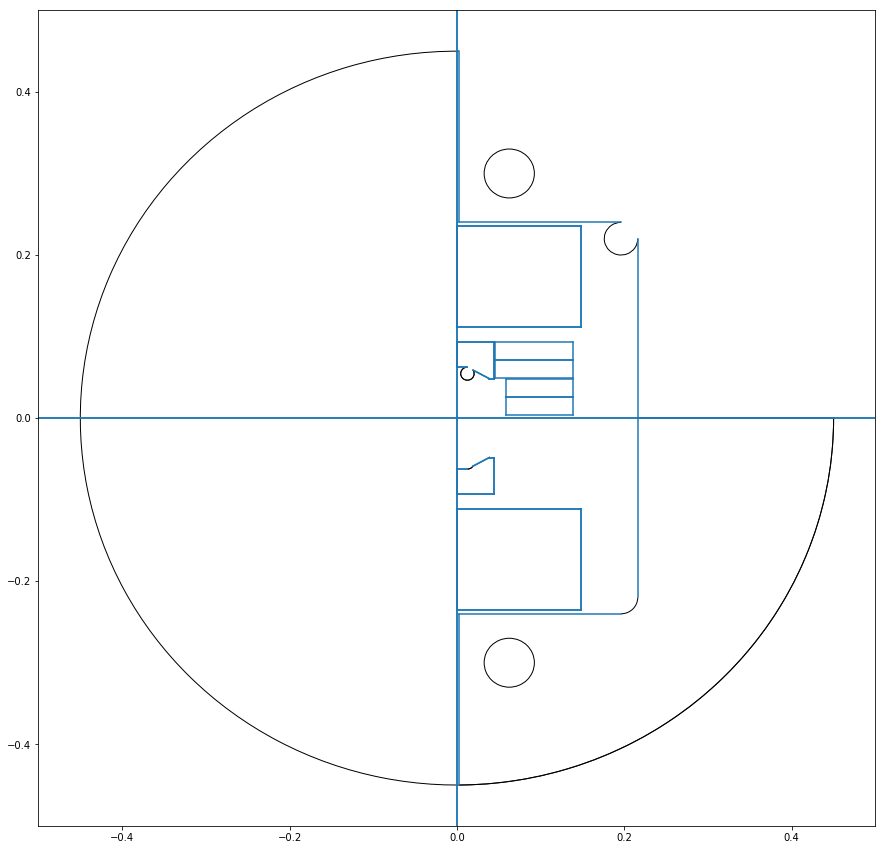

In [16]:
kp11 = Point.ofCartesian(138.42e-3, 25.3e-3)
kp12 = Point.ofCartesian(58.5e-3, 25.3e-3)
kp13 = Point.ofCartesian(58.5e-3, 3.5e-3)
kp14 = Point.ofCartesian(138.42e-3, 3.5e-3)
 
kp21 = Point.ofCartesian(138.42e-3, 47.6e-3)
kp22 = Point.ofCartesian(58.5e-3, 47.6e-3)
kp23 = Point.ofCartesian(58.5e-3, 25.8e-3)
kp24 = Point.ofCartesian(138.42e-3, 25.8e-3)
 
kp31 = Point.ofCartesian(138.42e-3, 70.9e-3)
kp32 = Point.ofCartesian(45.18e-3, 70.9e-3)
kp33 = Point.ofCartesian(45.18e-3, 49.1e-3)
kp34 = Point.ofCartesian(138.42e-3, 49.1e-3)
 
kp41 = Point.ofCartesian(138.42e-3, 93.2e-3)
kp42 = Point.ofCartesian(45.18e-3, 93.2e-3)
kp43 = Point.ofCartesian(45.18e-3, 71.4e-3)
kp44 = Point.ofCartesian(138.42e-3, 71.4e-3)
 
ln11 = Line.ofEndPoints(kp12,kp11)
ln12 = Line.ofEndPoints(kp12,kp13)
ln13 = Line.ofEndPoints(kp13,kp14)
ln14 = Line.ofEndPoints(kp11,kp14)
 
ln21 = Line.ofEndPoints(kp22,kp21)
ln22 = Line.ofEndPoints(kp22,kp23)
ln23 = Line.ofEndPoints(kp23,kp24)
ln24 = Line.ofEndPoints(kp21,kp24)
 
ln31 = Line.ofEndPoints(kp32,kp31)
ln32 = Line.ofEndPoints(kp32,kp33)
ln33 = Line.ofEndPoints(kp33,kp34)
ln34 = Line.ofEndPoints(kp31,kp34)
 
ln41 = Line.ofEndPoints(kp42,kp41)
ln42 = Line.ofEndPoints(kp42,kp43)
ln43 = Line.ofEndPoints(kp43,kp44)
ln44 = Line.ofEndPoints(kp41,kp44)

ha11p = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln11,ln12,ln13,ln14)))
ha12p = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln21,ln22,ln23,ln24)))
ha13p = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln31,ln32,ln33,ln34)))
ha14p = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln41,ln42,ln43,ln44)))

w11_R = Winding.ofAreas(a.create_area_array(gateway, (ha11p)), a.create_int_array(gateway, (+1, -1)), 36, 36, newCable_FRESCA2)
w12_R = Winding.ofAreas(a.create_area_array(gateway, (ha12p)), a.create_int_array(gateway, (+1, -1)), 36, 36, newCable_FRESCA2)
w13_R = Winding.ofAreas(a.create_area_array(gateway, (ha13p)), a.create_int_array(gateway, (+1, -1)), 42, 42, newCable_FRESCA2)
w14_R = Winding.ofAreas(a.create_area_array(gateway, (ha14p)), a.create_int_array(gateway, (+1, -1)), 42, 42, newCable_FRESCA2)


w11_R = w11_R.reverseWindingDirection()
w12_R = w12_R.reverseWindingDirection()
w13_R = w13_R.reverseWindingDirection()
w14_R = w14_R.reverseWindingDirection()

p1 = Pole.ofWindings(a.create_winding_array(gateway, (w11_R, w12_R, w13_R, w14_R)))
p2 = p1.mirrorX()

coil = Coil.ofPoles(a.create_pole_array(gateway, (p1, p2)))

p.plot_multiple_areas(ax, [ha11p, ha12p, ha13p, ha14p])
fig

In [20]:
# Assemble domains together
domains = a.create_domain_array(gateway, (AirDomain("AIR1", MatDatabase.MAT_AIR, air),
                AirFarFieldDomain("AIR2", MatDatabase.MAT_AIR, air_far_field),
                CoilDomain("COIL", MatDatabase.MAT_COIL, coil),
                IronDomain("IY1", MatDatabase.MAT_IRON1, iron_yoke1),
                IronDomain("IY2", MatDatabase.MAT_IRON1, iron_yoke2),
                HoleDomain("HY1", MatDatabase.MAT_AIR, iron_yoke_holes)))

In [21]:
# Create magnet model
cfg = ConfigSigma()
cfg.setOutputModelPath("MagnetModel.java")
cfg.setExternalCFunLibPath("U:\\STEAM\\MaterialsLibrary")

srv = TxtSigmaServer(cfg.getOutputModelPath(), cfg.getComsolBatchPath())
srv.connect(cfg.getComsolBatchPath())
m = MagnetMPHBuilder(cfg, srv)
m.buildMPH(domains)
m.save()

# Steps for the STEAM-SIGMA documentation to complete a model
<img src="../SolverSettings.PNG">
<img src="../PhysicsSettings.PNG">

# Magnetic field distribution
<img src="MagneticField.png">

# Extract differential inductance as a function of current

# Calculate differential inductance matrix

# Create equivalent electrical network with STEAM - preconditioner

# Create circuit to be coupled to